In [1]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from modSAR.datasource import ChEMBLApiDataSource, preprocess_activities
from modSAR.cdk_utils import JavaCDKBridge

/opt/conda/lib/python3.6/site-packages/grequests.py:21: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.contrib.pyopenssl (/opt/conda/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py)', 'urllib3.util (/opt/conda/lib/python3.6/site-packages/urllib3/util/__init__.py)']. 
  curious_george.patch_all(thread=False, select=False)


# Acquiring Data from ChEMBL

In [2]:
chembl_data_source = ChEMBLApiDataSource(target_id='CHEMBL202', standard_types=['IC50', 'Ki'])
result_df = chembl_data_source.bioactivities_df

Progress: |██████████████████████████████████████████████████| 100.0% Complete


A summary of the results

In [3]:
chembl_data_source

ChEMBLApiDataSource object
  target_id: CHEMBL202
  bioactivities: 1573
  standard_types: ['Ki' 'IC50' 'Log 1/Ki app' 'IC50/[E]' 'Ratio IC50']

In [4]:
result_df['standard_type'].value_counts()

IC50            1090
Ki               435
Log 1/Ki app      38
IC50/[E]           8
Ratio IC50         2
Name: standard_type, dtype: int64

# Preprocessing

- Select only valid entries
- Handle duplicated entries
- Remove data marked as outliers


In [5]:
preprocessed_df = preprocess_activities(result_df)

In [6]:
preprocessed_df.shape

(800, 51)

In [7]:
preprocessed_df.iloc[0]

activity_comment                                                          None
activity_id                                                              40879
assay_chembl_id                                                   CHEMBL858267
assay_description            Inhibition of human dihydrofolate reductase (D...
assay_type                                                                   B
bao_endpoint                                                              None
bao_format                                                         BAO_0000357
bao_label                                                single protein format
canonical_smiles                              CC1(C)N=C(N)N=C(N)N1c2cccc(Cl)c2
data_validity_comment                                                     None
data_validity_description                                                 None
document_chembl_id                                               CHEMBL1128273
document_journal                                    

Number of duplicated entries that existed in the dataset and were converted to a single entry:

In [8]:
preprocessed_df['duplicated'].sum()

188

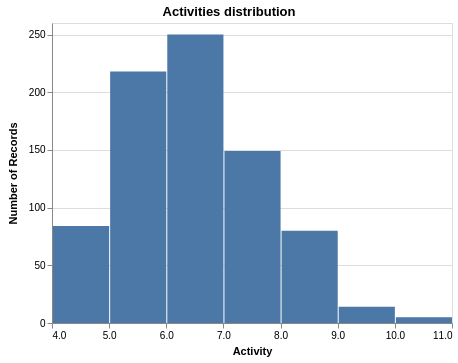

In [9]:
import altair as alt

alt.renderers.enable('notebook')

alt.Chart(preprocessed_df).mark_bar().encode(
    x=alt.X("median_pchembl_value", bin=True, title='Activity'),
    y='count()',
    tooltip=['count()'],
).properties(
    title='Activities distribution'
)


# Molecular Descriptors

In [9]:
java_cdk_bridge = JavaCDKBridge()
java_cdk_bridge.start_cdk_java_bridge()

b'jovyan     103  0.0  0.0   4504   740 ?        S    20:23   0:00 /bin/sh -c ps aux | grep CDK\njovyan     105  0.0  0.0  12944  1012 ?        S    20:23   0:00 grep CDK\n'


In [5]:
import py4j
gateway = java_cdk_bridge.gateway
py4j.java_gateway.find_jar_path()

'/opt/conda/share/py4j/py4j0.10.8.1.jar'

In [11]:
cdk = gateway.jvm.org.openscience.cdk

builder = cdk.DefaultChemObjectBuilder.getInstance()
smiles_parser = cdk.smiles.SmilesParser(builder)

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:25333)

## Descriptors List

In [ ]:
descriptors_list = pd.read_csv('/mnt/data/descriptors_list.csv')

def remove_prefix(java_class_name):
    return java_class_name.replace('org.openscience.', '') + '()'

descriptors_list['object_invocation'] = descriptors_list['descriptorClass'].apply(remove_prefix)
descriptors_list.head()

In [ ]:
descriptor = cdk.qsar.descriptors.molecular.BasicGroupCountDescriptor()
descriptor.initialise()

In [ ]:



def calculate_all_descriptors(data, descriptors_df):
    mol_container = smiles_parser.parseSmiles(data['canonical_smiles'])
    dict_descriptors = {}
    for i in range(descriptors_df.shape[0]):
        descriptor = eval(descriptors_df.iloc[i]['object_invocation'])
        descriptor.initialise(builder)
        descriptor_names = [desc_name for desc_name in descriptor.getDescriptorNames()]
        descriptor_values = descriptor.calculate(mol_container).getValue().toString().split(',')
        
        dict_descriptors.update({descriptor_names[j]: descriptor_values[j] 
                                 for j in range(len(descriptor_names))})
    
    result_df = pd.DataFrame(dict_descriptors, index=[data['parent_molecule_chembl_id']])
    return result_df

pd.concat([
    calculate_all_descriptors(preprocessed_df.iloc[1], descriptors_list),
    calculate_all_descriptors(preprocessed_df.iloc[0], descriptors_list)], axis=0)

In [ ]:
preprocessed_df.apply(calculate_all_descriptors, axis=1, descriptors_df=descriptors_list)

In [ ]:
py4j.java_gateway.get_field(descriptor, 'CHECK_RING_SYSTEM')

In [ ]:
[f for f in descriptor.getParameters()]

In [ ]:
gateway.jvm.java.lang.Object()

In [ ]:
descriptor.setParameters(['false'])

In [ ]:
descriptor = cdk.qsar.descriptors.molecular.LongestAliphaticChainDescriptor()
mol_container = smiles_parser.parseSmiles(preprocessed_df.iloc[2]['canonical_smiles'])
descriptor.calculate(mol_container).getValue().toString().split(',')

In [ ]:
m = Chem.MolFromSmiles(preprocessed_df.iloc[3]['canonical_smiles'])
m

In [ ]:
AllChem.CalcKappa1(m)

In [ ]:
result_df.columns.tolist()